In [4]:
import pandas as pd 
from sklearn.metrics import roc_auc_score, average_precision_score
from matplotlib import pyplot as plt
import numpy as np

In [7]:
res = pd.read_csv('../jglaser/predictions.csv')

# remove microRNAs from predicted binding affinity (predictions results)
res = res[lambda x: ~x.gene_symbol.str.startswith('MIR')]

res.head()

,drug_idx,prot_idx,inchikey,gene_symbol,in_targetome,kd_score,kd_lcb,kd_ucb
0,0,0,HPLNQCPCUACXLM-PGUFJCEWSA-N,A1BG,False,-0.235358,-1.070266,0.987870
1,0,1,HPLNQCPCUACXLM-PGUFJCEWSA-N,A1CF,False,-0.197051,-1.273620,0.907095
2,0,2,HPLNQCPCUACXLM-PGUFJCEWSA-N,A2M,False,-0.338461,-1.345509,0.714370
3,0,3,HPLNQCPCUACXLM-PGUFJCEWSA-N,A3GALT2,False,-0.661544,-1.714088,0.176495
4,0,4,HPLNQCPCUACXLM-PGUFJCEWSA-N,A4GALT,False,-0.536260,-1.078609,0.336331


In [9]:
auroc = roc_auc_score(res.in_targetome, res.kd_score)
aupr = average_precision_score(res.in_targetome, res.kd_score)
print('Targetome AUROC score:', auroc)
print('Targetome AUPR score:', aupr)

Targetome AUROC score: 0.6968779004953649
Targetome AUPR score: 0.00772289882122324


In [10]:
q10, q90 = np.quantile(res.kd_score, [0.1, 0.9])

res = res.assign(weak_binders = lambda x: x.kd_score < q10) 
res = res.assign(strong_binders = lambda x: x.kd_score > q90)

res = res.assign(conf_weak = lambda x: x.kd_ucb < np.quantile(res.kd_ucb, 0.025))
res = res.assign(conf_strong = lambda x: x.kd_lcb > np.quantile(res.kd_lcb, 0.975))

print('# weak binders:', res.weak_binders.sum())
print('# strong binders:', res.strong_binders.sum())

print('# confident weak binders:', res.conf_weak.sum())
print('# confident strong binders:', res.conf_strong.sum())

print('# targetome in conf weak binders', res.query('in_targetome and conf_weak').shape[0])
print('# targetome not in conf weak binders', res.query('in_targetome and not conf_weak').shape[0])

print('# targetome in conf strong binders', res.query('in_targetome and conf_strong').shape[0])
print('# targetome not in conf strong binders', res.query('in_targetome and not conf_strong').shape[0])

res.head()

# weak binders: 116145
# strong binders: 116145
# confident weak binders: 29037
# confident strong binders: 29037
# targetome in conf weak binders 9
# targetome not in conf weak binders 3223
# targetome in conf strong binders 338
# targetome not in conf strong binders 2894


,drug_idx,prot_idx,inchikey,gene_symbol,in_targetome,kd_score,kd_lcb,kd_ucb,weak_binders,strong_binders,conf_weak,conf_strong
0,0,0,HPLNQCPCUACXLM-PGUFJCEWSA-N,A1BG,False,-0.235358,-1.070266,0.987870,False,False,False,False
1,0,1,HPLNQCPCUACXLM-PGUFJCEWSA-N,A1CF,False,-0.197051,-1.273620,0.907095,False,False,False,False
2,0,2,HPLNQCPCUACXLM-PGUFJCEWSA-N,A2M,False,-0.338461,-1.345509,0.714370,False,False,False,False
3,0,3,HPLNQCPCUACXLM-PGUFJCEWSA-N,A3GALT2,False,-0.661544,-1.714088,0.176495,False,False,False,False
4,0,4,HPLNQCPCUACXLM-PGUFJCEWSA-N,A4GALT,False,-0.536260,-1.078609,0.336331,False,False,False,False


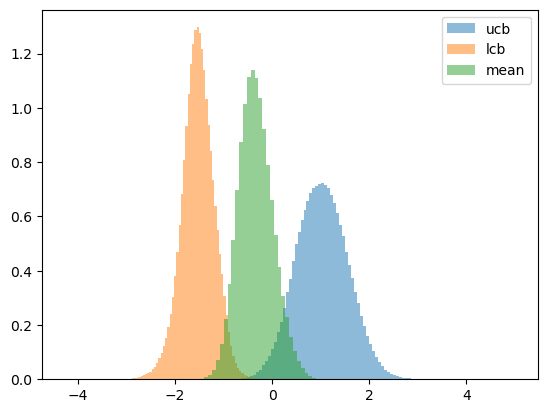

In [11]:
plt.figure() 
plt.hist(res.kd_ucb, bins=100, alpha=0.5, label='ucb', density=True)
plt.hist(res.kd_lcb, bins=100, alpha=0.5, label='lcb', density=True)
plt.hist(res.kd_score, bins=100, alpha=0.5, label='mean', density=True)
plt.legend()
plt.show()

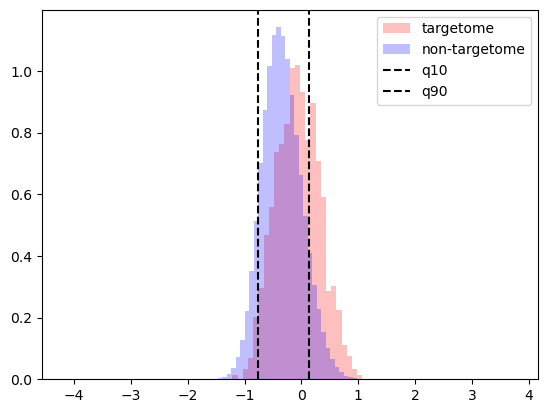

In [12]:
plt.figure()
plt.hist(res[lambda x: x.in_targetome].kd_score, bins=25, alpha=0.25, density=True, color='r', label='targetome')
plt.hist(res[lambda x: ~x.in_targetome].kd_score, bins=100, alpha=0.25, density=True, color='b', label='non-targetome')
plt.axvline(q10, color='k', linestyle='--', label='q10')
plt.axvline(q90, color='k', linestyle='--', label='q90')
plt.legend()
plt.show()

In [13]:
# MLE weak binders 
weak_binders_fwd = res[lambda x: x.weak_binders].rename({'inchikey':'src', 'gene_symbol':'dst'}, axis=1)
weak_binders_fwd = weak_binders_fwd.assign(src_type = 'drug', dst_type = 'gene', relation = 'predicted_weak_binding_fwd')
weak_binders_fwd = weak_binders_fwd[['src', 'dst', 'src_type', 'dst_type', 'relation']]
weak_binders_fwd.to_csv('../../extdata/relations/jglaser__predicted_weak_binding_fwd.csv', index=False)

weak_binders_rev = res[lambda x: x.weak_binders].rename({'inchikey':'dst', 'gene_symbol':'src'}, axis=1)
weak_binders_rev = weak_binders_rev.assign(src_type = 'gene', dst_type = 'drug', relation = 'predicted_weak_binding_rev')
weak_binders_rev = weak_binders_rev[['src', 'dst', 'src_type', 'dst_type', 'relation']]
weak_binders_rev.to_csv('../../extdata/relations/jglaser__predicted_weak_binding_rev.csv', index=False)

# MLE strong binders 
strong_binders_fwd = res[lambda x: x.strong_binders].rename({'inchikey':'src', 'gene_symbol':'dst'}, axis=1)
strong_binders_fwd = strong_binders_fwd.assign(src_type = 'drug', dst_type = 'gene', relation = 'predicted_strong_binding_fwd')
strong_binders_fwd = strong_binders_fwd[['src', 'dst', 'src_type', 'dst_type', 'relation']]
strong_binders_fwd.to_csv('../../extdata/relations/jglaser__predicted_strong_binding_fwd.csv', index=False)

strong_binders_rev = res[lambda x: x.strong_binders].rename({'inchikey':'dst', 'gene_symbol':'src'}, axis=1)
strong_binders_rev = strong_binders_rev.assign(src_type = 'gene', dst_type = 'drug', relation = 'predicted_strong_binding_rev')
strong_binders_rev = strong_binders_rev[['src', 'dst', 'src_type', 'dst_type', 'relation']]
strong_binders_rev.to_csv('../../extdata/relations/jglaser__predicted_strong_binding_rev.csv', index=False)

# confidently weak binders 
conf_weak_binders_fwd = res[lambda x: x.conf_weak].rename({'inchikey':'src', 'gene_symbol':'dst'}, axis=1)
conf_weak_binders_fwd = conf_weak_binders_fwd.assign(src_type = 'drug', dst_type = 'gene', relation = 'predicted_conf_weak_binding_fwd')
conf_weak_binders_fwd = conf_weak_binders_fwd[['src', 'dst', 'src_type', 'dst_type', 'relation']]
conf_weak_binders_fwd.to_csv('../../extdata/relations/jglaser__predicted_conf_weak_binding_fwd.csv', index=False)

conf_weak_binders_rev = res[lambda x: x.conf_weak].rename({'inchikey':'dst', 'gene_symbol':'src'}, axis=1)
conf_weak_binders_rev = conf_weak_binders_rev.assign(src_type = 'gene', dst_type = 'drug', relation = 'predicted_conf_weak_binding_rev')
conf_weak_binders_rev = conf_weak_binders_rev[['src', 'dst', 'src_type', 'dst_type', 'relation']]
conf_weak_binders_rev.to_csv('../../extdata/relations/jglaser__predicted_conf_weak_binding_rev.csv', index=False)